In [2]:
#Import libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
import keras_tuner as kt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
#load in our dataset
df = pd.read_csv("Resources/mountain_pastured_cows.csv")
display(df.head())

,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72


### Data Exploration and Cleaning

In [4]:
#check dtypes
df.dtypes

newid               int64
lact_num            int64
calv_date          object
alp_date           object
avg_milk          float64
avg_thi3          float64
avg_csi3          float64
avg_thi30         float64
avg_csi30         float64
avg_precspring    float64
dtype: object

In [5]:
#check for nulls, negligible amount, should be clear to dropna
print(df.isna().sum()/len(df))
print(df.shape)

newid             0.00000
lact_num          0.00000
calv_date         0.00000
alp_date          0.00000
avg_milk          0.00000
avg_thi3          0.00205
avg_csi3          0.00205
avg_thi30         0.00205
avg_csi30         0.00205
avg_precspring    0.00000
dtype: float64
(20000, 10)


In [6]:
df = df.dropna()
print(df.shape)

(19959, 10)


In [7]:
df["avg_milk"].describe()

count    19959.000000
mean        15.921083
std          4.078102
min          3.500000
25%         13.070000
50%         15.600000
75%         18.500000
max         40.370000
Name: avg_milk, dtype: float64

In [8]:
# The most frequently produced milk production value (mode)
mode_milk = stats.mode(df['avg_milk'])[0]  

# Print the mode
print(f"Mode of avg_milk: {mode_milk}") 

Mode of avg_milk: 14.6


In [9]:
# For the Target column ("Y"), avg_milk production, calculate the number of cows for the min and max, 
# and calculate the cumulative number of cows at quartiles 25%, 50% and 75% (moooooooooooooooo!!!!)
min_milk_count = (df['avg_milk'] == df['avg_milk'].min()).sum()
max_milk_count = (df['avg_milk'] == df['avg_milk'].max()).sum()
p25_count = (df['avg_milk'] < df['avg_milk'].quantile(0.25)).sum()
p50_count = (df['avg_milk'] < df['avg_milk'].quantile(0.50)).sum()
p75_count = (df['avg_milk'] < df['avg_milk'].quantile(0.75)).sum()

# print the cumlative number of cows below the certain thresholds)
print(f"Number of cows with minimum milk production (3.5 kg): {min_milk_count}")
print(f"Number of cows with maximum milk production (40.37 kg): {max_milk_count}")
print(f"Number of cows that produced less than the 25th percentile (13.07 kg): {p25_count}") 
print(f"Number of cows that produced less than the median (15.60 kg): {p50_count}")
print(f"Number of cows that produced less than the 75th percentile (18.50 kg): {p75_count}")


Number of cows with minimum milk production (3.5 kg): 1
Number of cows with maximum milk production (40.37 kg): 2
Number of cows that produced less than the 25th percentile (13.07 kg): 4979
Number of cows that produced less than the median (15.60 kg): 9911
Number of cows that produced less than the 75th percentile (18.50 kg): 14965


In [10]:
# Extact from the dataset and examine the data of the cow with exceptionally low milk yield to gather some insight behind these values.

# Find the cow(s) that produced 3.5 kg of milk
cows_with_min_milk = df[df['avg_milk'] == 3.5] 
cows_with_min_milk


,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring
3844,37340,2,2001-09-29,2002-07-03,3.5,59.18,1091.85,60.98,1040.56,186.71


In [11]:
# Extact from the dataset and examine the data of the cow with exceptionally high milk yield to gather some insight behind these values.

# Find the cow(s) that produced 40.37 kg of milk:
cows_with_max_milk = df[df['avg_milk'] == 40.37] 
cows_with_max_milk

,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring
3923,176146,8,2013-09-28,2013-10-09,40.37,44.27,1088.68,46.34,1140.58,182.28
6922,376495,8,2013-09-28,2013-10-09,40.37,44.27,1088.68,46.34,1140.58,182.28


Number of cows within 1 standard deviation: 13753
Number of cows within 2 standard deviations: 19067
Number of cows within 3 standard deviations: 19865


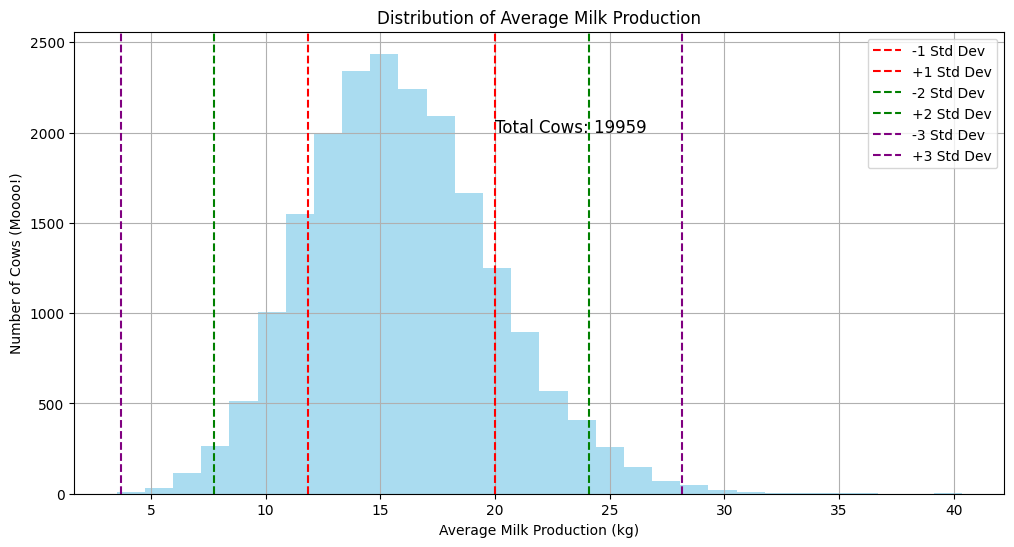

In [12]:
# For the defined target Column ("Y"), avg_milk production, 
# calculate and observe the number of cows within 1 standard deviation, 2 and 3 standard deviations and graph the results 

# Extract relevant statistics
mean = 15.921083
std_dev = 4.078102
total_cows = 19959

# Calculate standard deviation boundaries
lower_bound_1std = mean - std_dev
upper_bound_1std = mean + std_dev
lower_bound_2std = mean - 2 * std_dev
upper_bound_2std = mean + 2 * std_dev
lower_bound_3std = mean - 3 * std_dev
upper_bound_3std = mean + 3 * std_dev

# Count cows within standard deviation ranges 
num_cows_within_1std = ((df['avg_milk'] >= lower_bound_1std) & (df['avg_milk'] <= upper_bound_1std)).sum()
num_cows_within_2std = ((df['avg_milk'] >= lower_bound_2std) & (df['avg_milk'] <= upper_bound_2std)).sum()
num_cows_within_3std = ((df['avg_milk'] >= lower_bound_3std) & (df['avg_milk'] <= upper_bound_3std)).sum()

# Print the number of cows within each standard deviation range
print(f"Number of cows within 1 standard deviation: {num_cows_within_1std}")
print(f"Number of cows within 2 standard deviations: {num_cows_within_2std}")
print(f"Number of cows within 3 standard deviations: {num_cows_within_3std}")

# Create the histogram
plt.figure(figsize=(12, 6))

plt.hist(df['avg_milk'], bins=30, color='skyblue', alpha=0.7)

# Plot vertical lines for standard deviations
plt.axvline(lower_bound_1std, color='red', linestyle='--', label='-1 Std Dev')
plt.axvline(upper_bound_1std, color='red', linestyle='--', label='+1 Std Dev')
plt.axvline(lower_bound_2std, color='green', linestyle='--', label='-2 Std Dev')
plt.axvline(upper_bound_2std, color='green', linestyle='--', label='+2 Std Dev')
plt.axvline(lower_bound_3std, color='purple', linestyle='--', label='-3 Std Dev')
plt.axvline(upper_bound_3std, color='purple', linestyle='--', label='+3 Std Dev')

# Add labels and title
plt.xlabel('Average Milk Production (kg)')
plt.ylabel('Number of Cows (Moooo!)')
plt.title('Distribution of Average Milk Production')
plt.legend()

# Add gridlines
plt.grid(True)

# Add total number of cows as text
plt.text(20, 2000, f"Total Cows: {total_cows}", fontsize=12)

plt.show()

### Feature Engineering

In [13]:
# Example: converting 'calv_date' and 'alp_date' columns to datetime
df['calv_date'] = pd.to_datetime(df['calv_date'])
df['alp_date'] = pd.to_datetime(df['alp_date'])

display(df.head())
print(df.dtypes)


,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72


newid                      int64
lact_num                   int64
calv_date         datetime64[ns]
alp_date          datetime64[ns]
avg_milk                 float64
avg_thi3                 float64
avg_csi3                 float64
avg_thi30                float64
avg_csi30                float64
avg_precspring           float64
dtype: object


In [14]:
# Calculate the difference
df['date_diff'] = (df['alp_date'] - df['calv_date']).dt.days

df.head()

,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring,date_diff
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61,106
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40,218
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08,281
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96,254
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72,262


In [15]:
#Replace datetime columns with numerical

# df['calv_year'] = df['calv_date'].dt.year | causes multicollinearity issues
df['calv_month'] = df['calv_date'].dt.month
df['calv_day_of_month'] = df['calv_date'].dt.day

# df['alp_year'] = df['alp_date'].dt.year | causes multicollinearity issues
df['alp_month'] = df['alp_date'].dt.month
df['alp_day_of_month'] = df['alp_date'].dt.day

df.head()

,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring,date_diff,calv_month,calv_day_of_month,alp_month,alp_day_of_month
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61,106,2,19,6,5
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40,218,11,9,6,15
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08,281,9,16,6,24
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96,254,10,18,6,29
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72,262,9,14,6,2


In [16]:
df.dtypes

newid                         int64
lact_num                      int64
calv_date            datetime64[ns]
alp_date             datetime64[ns]
avg_milk                    float64
avg_thi3                    float64
avg_csi3                    float64
avg_thi30                   float64
avg_csi30                   float64
avg_precspring              float64
date_diff                     int64
calv_month                    int32
calv_day_of_month             int32
alp_month                     int32
alp_day_of_month              int32
dtype: object

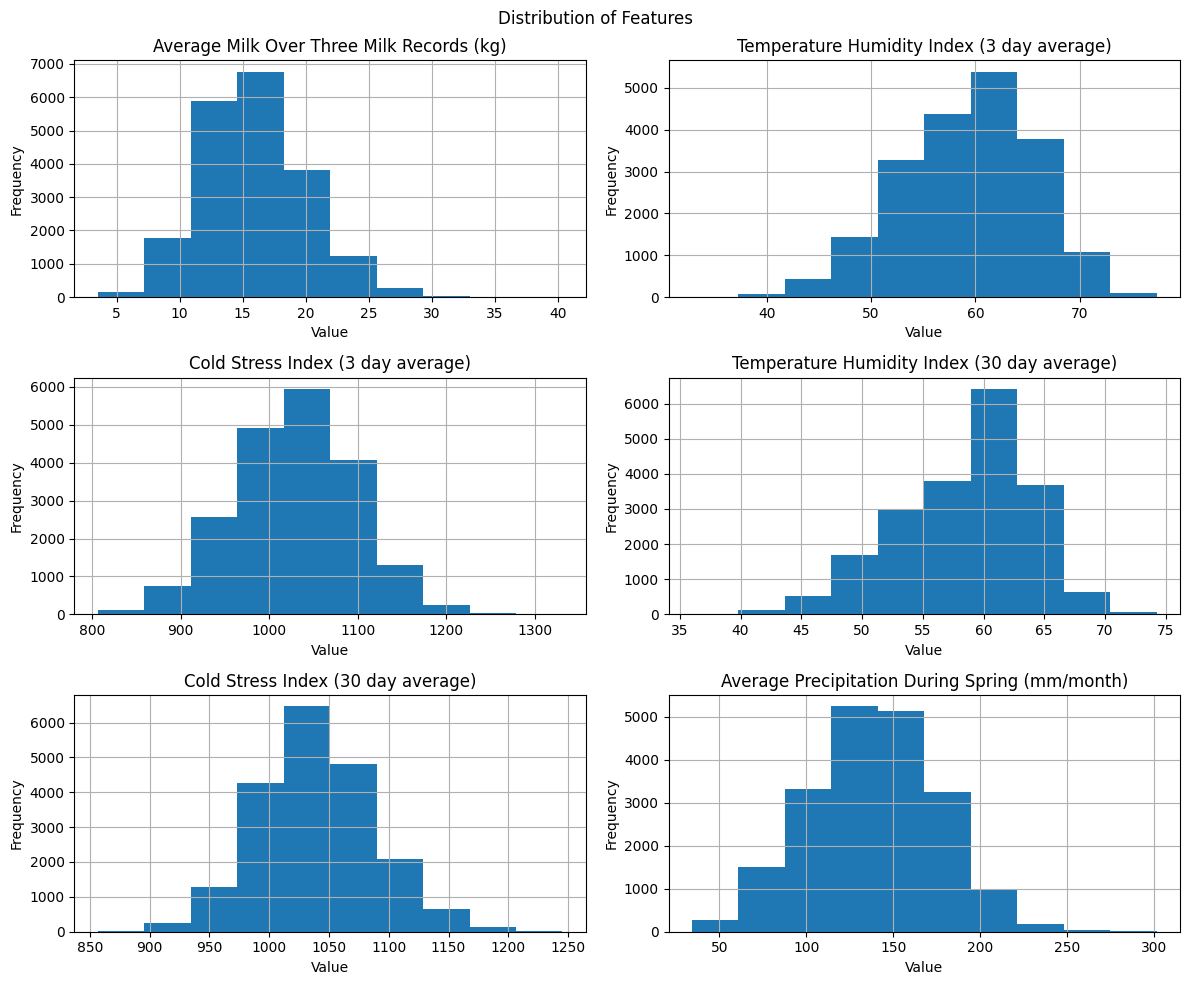

<Figure size 640x480 with 0 Axes>

In [17]:
# Visualize distributions of numeric columns
numeric_columns = ['avg_milk', 'avg_thi3', 'avg_csi3', 'avg_thi30', 'avg_csi30', 'avg_precspring']
axes = df[numeric_columns].hist(figsize=(12, 10))
plt.suptitle("Distribution of Features")
# Add Labels for each fig
titles = ['Average Milk Over Three Milk Records (kg)', 'Temperature Humidity Index (3 day average)', 'Cold Stress Index (3 day average)',
          'Temperature Humidity Index (30 day average)','Cold Stress Index (30 day average)', 'Average Precipitation During Spring (mm/month)']
xlabel = "Value"
ylabel = "Frequency"
for fig, title in zip(axes.flatten(), titles):
    fig.set_title(title)
    fig.set_xlabel(xlabel)
    fig.set_ylabel(ylabel)
# show charts
plt.tight_layout()
plt.show()
plt.savefig('Resources/milk_histogram.svg')

### Data Leakage 

In [18]:
# remove problematic or no longer needed columns
# removing dates because features were extracted from these values and the originals are no longer needed.
# removing avg_thi30 because it causes high VIF scores
df = df.drop(["newid",'avg_thi30', 'calv_date', 'alp_date'], axis = 1)
df.head()

,lact_num,avg_milk,avg_thi3,avg_csi3,avg_csi30,avg_precspring,date_diff,calv_month,calv_day_of_month,alp_month,alp_day_of_month
0,5,26.20,60.17,966.13,1038.28,134.61,106,2,19,6,5
1,5,12.20,66.08,917.76,1111.54,184.40,218,11,9,6,15
2,3,14.60,66.78,899.06,1000.32,184.08,281,9,16,6,24
3,5,15.17,63.49,1053.80,1037.26,116.96,254,10,18,6,29
4,1,12.03,65.96,969.90,998.60,154.72,262,9,14,6,2


In [19]:
df.columns

Index(['lact_num', 'avg_milk', 'avg_thi3', 'avg_csi3', 'avg_csi30',
       'avg_precspring', 'date_diff', 'calv_month', 'calv_day_of_month',
       'alp_month', 'alp_day_of_month'],
      dtype='object')

In [20]:
features = ['lact_num', 'avg_milk', 'avg_thi3', 'avg_csi3', 'avg_csi30',
       'avg_precspring', 'date_diff', 'calv_month',
       'calv_day_of_month', 'alp_month', 'alp_day_of_month']

# Calculate VIF
X = df[features]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [vif(X.values, i) for i in range(X.shape[1])]

print(vif_data)

              Feature          VIF
0               const  4350.541432
1            lact_num     1.093165
2            avg_milk     1.583383
3            avg_thi3     6.963646
4            avg_csi3     3.926807
5           avg_csi30     2.587901
6      avg_precspring     1.268668
7           date_diff     2.117705
8          calv_month     2.834302
9   calv_day_of_month     1.015470
10          alp_month     1.502374
11   alp_day_of_month     1.388929


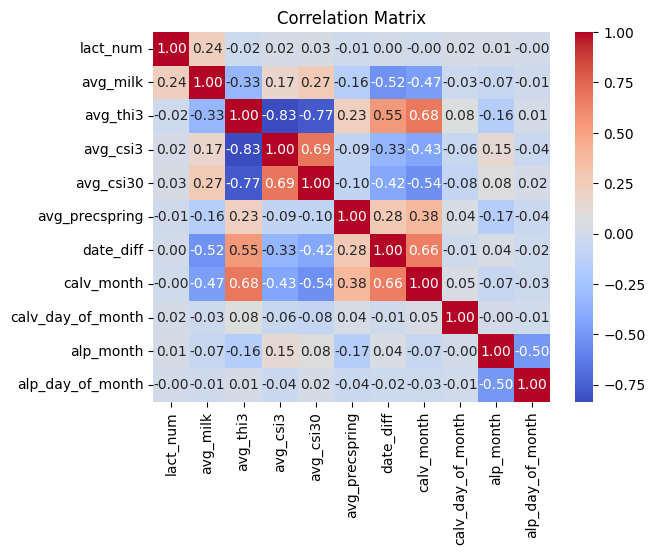

In [21]:
corr_matrix = df[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Model Training 

In [22]:
# Split the features and target data
y = df['avg_milk']
X = df.drop('avg_milk', axis = 1)


In [23]:
# Review the features Dataframe 
display(X.head())
display(y)

,lact_num,avg_thi3,avg_csi3,avg_csi30,avg_precspring,date_diff,calv_month,calv_day_of_month,alp_month,alp_day_of_month
0,5,60.17,966.13,1038.28,134.61,106,2,19,6,5
1,5,66.08,917.76,1111.54,184.40,218,11,9,6,15
2,3,66.78,899.06,1000.32,184.08,281,9,16,6,24
3,5,63.49,1053.80,1037.26,116.96,254,10,18,6,29
4,1,65.96,969.90,998.60,154.72,262,9,14,6,2


0        26.20
1        12.20
2        14.60
3        15.17
4        12.03
         ...  
19995    19.38
19996    23.57
19997    21.23
19998    11.63
19999    10.47
Name: avg_milk, Length: 19959, dtype: float64

In [24]:
# Split data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [25]:
# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

display(X_train_scaled)
display(X_test_scaled)

array([[-0.30741166, -0.21155819,  0.13192995, ...,  0.72095697,
        -1.96420227,  1.46995656],
       [ 0.77316723, -0.92933445,  1.23760228, ...,  1.29769942,
        -0.0429958 , -0.49693931],
       [ 0.77316723,  0.20266511, -0.55633228, ...,  1.5283964 ,
        -0.0429958 ,  1.00715753],
       ...,
       [-0.84770111, -2.32219983,  1.51317257, ..., -0.54787644,
        -0.0429958 ,  0.66005826],
       [-0.30741166, -1.31193765,  1.0039057 , ...,  0.72095697,
        -0.0429958 ,  0.19725924],
       [-0.84770111,  0.52835213, -0.04441145, ...,  0.60560848,
        -0.0429958 , -1.65393688]])

array([[-0.30741166,  0.43665384, -0.35566286, ..., -0.31717945,
        -0.0429958 ,  1.46995656],
       [ 0.77316723, -1.02419475,  0.92340202, ...,  1.75909339,
        -0.0429958 , -0.95973833],
       [-0.84770111, -0.20365317, -0.2365292 , ..., -0.54787644,
        -1.96420227,  0.77575802],
       ...,
       [ 0.77316723,  1.69197179, -1.64165754, ...,  0.259563  ,
        -1.96420227,  1.3542568 ],
       [ 0.23287778, -1.17280921,  0.7967488 , ..., -1.47066437,
        -0.0429958 , -0.95973833],
       [-0.84770111,  1.08960889, -1.31315534, ...,  0.02886602,
        -0.0429958 , -0.38123955]])

## Define the ANN Model

### Create and fit feedforward ANN Model 

In [26]:
# Define the ANN Model
model1 = Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),  # Input layer
    layers.Dense(32, activation='relu'),  # Hidden layer 1
    layers.Dense(32, activation='relu'),  # Hidden layer 2
    layers.Dense(1)  # Output layer
])

In [27]:
# Compile the ANN ›model
model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [56]:
# Fit the model
history1 = model1.fit(X_train_scaled, y_train, epochs=100, batch_size=10, validation_split=0.2)

Epoch 1/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.6622 - mae: 2.2977 - val_loss: 9.7944 - val_mae: 2.4374
Epoch 2/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.5115 - mae: 2.2828 - val_loss: 10.6770 - val_mae: 2.5909
Epoch 3/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.7384 - mae: 2.3029 - val_loss: 9.6690 - val_mae: 2.4215
Epoch 4/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.0235 - mae: 2.3295 - val_loss: 9.6895 - val_mae: 2.4251
Epoch 5/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - loss: 8.6122 - mae: 2.2972 - val_loss: 9.6691 - val_mae: 2.4347
Epoch 6/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.6957 - mae: 2.3131 - val_loss: 9.8413 - val_mae: 2.4609
Epoch 7/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - loss: 8.8291 - mae: 2.3178 - val_loss: 9.6485 - val_mae: 2.4257
Epoch 8/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - loss: 8.6657 - mae: 2.2966 - val_loss: 9.8056 - val_mae: 2.4381
Epoch 9/100
1198/1198 ━━━

In [29]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,325 (16.90 KB)

 Trainable params: 1,441 (5.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,884 (11.27 KB)

In [30]:
# Evaluate the model
loss, mae = model1.evaluate(X_test_scaled, y_test)
print(f'Mean Absolute Error: {mae}')

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 9.4228 - mae: 2.4016
Mean Absolute Error: 2.438178777694702


In [31]:
# Calculate MAE (For readressing  / review)
y_pred = model1.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mae

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


2.438178396702768

In [32]:
len(X.columns)

10

In [51]:
def create_model(hp):
    model = tf.keras.models.Sequential()
    
    #choose which activation function to use for hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])

    #choose number of neurons in the first layer
    model.add(layers.Input(shape=(len(X.columns),)))
    model.add(layers.Dense(units = hp.Int('first_units', min_value = 1, max_value = 10, step=2),
                                       activation = activation))

    #choose number of hidden layers and number of neurons
    for i in range(hp.Int('num_layers', 1, 6)):
        model.add(layers.Dense(units = hp.Int('units_' + str(i),  min_value = 1, max_value = 10, step = 2),
                               activation = activation))

    #add final layer for regression
    model.add(layers.Dense(units = 1))

    #find best learning rate
    learning_rate = hp.Choice('learning_rate', [0.001, 0.01, 0.1])

    #choose the optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    #compile the model
    model.compile(loss = "mean_absolute_error", optimizer = optimizer, metrics = ["mean_absolute_error"])

    return model      
  

In [52]:
# set up the tuner
tuner = kt.Hyperband(create_model,                           #run function
                     objective = 'mean_absolute_error',      #what are we testing for
                     max_epochs = 20,                        #testing on how many iterations
                     hyperband_iterations = 2)               #how many times to run the tuner

In [53]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled, y_train,
             epochs=20, 
             validation_data=(X_test_scaled, y_test),
            batch_size=kt.HyperParameters().Choice('batch_size', [16, 32, 64, 128]))

Trial 60 Complete [00h 00m 21s]
mean_absolute_error: 2.4281206130981445

Best mean_absolute_error So Far: 2.4079010486602783
Total elapsed time: 00h 09m 19s


Epoch 1/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.3576 - mean_absolute_error: 2.3576 - val_loss: 2.4337 - val_mean_absolute_error: 2.4337
Epoch 2/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.3908 - mean_absolute_error: 2.3908 - val_loss: 2.4382 - val_mean_absolute_error: 2.4382
Epoch 3/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.3640 - mean_absolute_error: 2.3640 - val_loss: 2.4324 - val_mean_absolute_error: 2.4324
Epoch 4/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.3920 - mean_absolute_error: 2.3920 - val_loss: 2.4315 - val_mean_absolute_error: 2.4315
Epoch 5/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.3829 - mean_absolute_error: 2.3829 - val_loss: 2.4362 - val_mean_absolute_error: 2.4362
Epoch 6/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.3965 - mean_absolute_error: 2.3965 - val_loss: 2.4311 - val_mean_absolute_error: 2.4311
Epoch 7/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.3968 - mean_absolute_error: 2.3

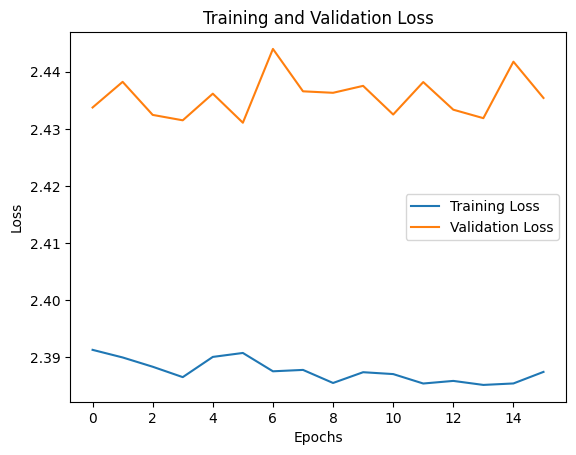

In [55]:
# Calculate MAE (For readressing  / review)
history = model.fit(X_train_scaled, y_train, 
                         epochs=100,  # A large number to let early stopping work
                         validation_data=(X_test_scaled, y_test),
                         callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mae
# Plot training and validation loss to visualize overfitting prevention
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [36]:
# Get best model hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
best_hp.values

{'activation': 'relu',
 'first_units': 7,
 'num_layers': 5,
 'units_0': 1,
 'learning_rate': 0.01,
 'optimizer': 'sgd',
 'units_1': 5,
 'units_2': 9,
 'units_3': 3,
 'units_4': 3,
 'units_5': 3,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [37]:
# Retrieve the best model
model = tuner.get_best_models(num_models=1)[0]

# Print the summary of the best model
model.summary()

C:\Users\jclib\anaconda3\envs\dev\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 7)                   │              77 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               8 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │              54 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 195 (780.00 B)

 Trainable params: 195 (780.00 B)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Export our model and our scaler for use in out gradio notebook
from pathlib import Path
file_path = Path("milking_the_data.keras")
model.save(file_path)

import pickle
# Save the scaler to a file using pickle
with open('X_scaler.pkl', 'wb') as f:
    pickle.dump(X_scaler, f)